In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import os
from math import sqrt 
import sys
import time
import threading

In [121]:
no_info_search_algo = ['dfs', 'bfs', 'ucs']
info_search_algo = ['gbfs', 'astar']
heuristic_list = ['manhattan_distance', 'euclidean_distance', 'chebyshev_distance']

def read_maze(file_name):
    maze = None
    if os.path.getsize(file_name) > 0:
        with open(file_name, "r") as f:
            n = int(f.readline())

            plus_point = [] #read list of plus point
            for i in range(n):
                point = [int(x) for x in f.readline().split(' ')]
                point[2] = -point[2]
                plus_point.append(point)

            maze = [] #read maze
            for line in f:
                if line[-1] == '\n': line = line[:-1]
                maze.append([x for x in line])

            for point in plus_point: #embed plus point to maze
                maze[point[0]][point[1]] = point[2]

            for i,x in enumerate(maze[0]): 
                if x == ' ': maze[0][i] = 'G'
            for i,x in enumerate(maze[-1]): 
                if x == ' ': maze[-1][i] = 'G'
            for line in maze[1:-1]:
                if line[0] == ' ': line[0] = 'G'
                if line[-1] == ' ': line[-1] = 'G'
            
    return maze
            
def encode_char(char):
    if char == 'x': return 0
    if char == 'S': return 255
    if char == ' ': return 170
    if char == 'P': return 235
    if char == 'V': return 200
    if char == 'F': return 220
    if char == 'G': return 240
    return 120 - int(char) * 9

def upscale(maze, scale): #upscale maze for saving
    new_maze = np.zeros([np.shape(maze)[0] * scale, np.shape(maze)[1] * scale])
    for i in range(np.shape(maze)[0]):
        for j in range(np.shape(maze)[1]):
            new_maze[i * scale : (i + 1) * scale, j * scale : (j + 1) * scale] = maze[i][j]
    return new_maze

def update_maze(maze, frontier, visited, path, start, goal):
    #update maze status after each iteration
    new_maze = copy.deepcopy(maze)
    for i in range(len(new_maze)):
        for j in range(len(new_maze[i])):
            if [i, j] in [x[0:2] for x in visited]:
                new_maze[i][j] = 'V'
            if [i, j] in [x[0:2] for x in frontier]:
                new_maze[i][j] = 'F'
            if [i, j] in [x[0:2] for x in path]:
                new_maze[i][j] = 'P'
            if [i, j] == start:
                new_maze[i][j] = 'S'

    return new_maze
def get_neighbors(current, maze):
    neighbors = []
    if current[0] > 0:
        neighbors.append([current[0] - 1, current[1]])
    if current[0] < len(maze) - 1:
        neighbors.append([current[0] + 1, current[1]])
    if current[1] > 0:
        neighbors.append([current[0], current[1] - 1])
    if current[1] < len(maze[0]) - 1:
        neighbors.append([current[0], current[1] + 1])

    return neighbors

def tracing(trace, goal, start):
    path = []
    current = goal
    while current != start:
        path.append(current)
        current = trace[current[0]][current[1]]
    return path

def find_start_goal(maze):
    start = [0, 0]
    goal = [0, 0]
    #find start and goal point
    for i in range(len(maze)):
        for j in range(len(maze[i])):
            if maze[i][j] == 'S':
                start = [i, j]
            if maze[i][j] == 'G':
                goal = [i, j]
    return start, goal

def init_search(maze):
    start, goal = find_start_goal(maze)
    frontier = [start]
    visited = [] 
    path = []
    trace = [[[0, 0, 0] for i in range(len(maze[0]))] for j in range(len(maze))]
    iter_maze = [maze]
    return start, goal, frontier, visited, path, trace, iter_maze

def show_maze(maze):
    encoded_maze = [[encode_char(x) for x in line] for line in maze]

    fig = plt.figure()

    plt.xticks(color = 'w')
    plt.yticks(color = 'w')
    plt.tick_params(bottom = False, left = False)

    plt.imshow(encoded_maze, cmap = 'rainbow')
    plt.show()

def save_maze(maze, step, exe_time, folder_name, file_name, algo, heuristic = ''): #save result maze to folder
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    encoded_maze = [list(map(encode_char, line)) for line in maze]
    upscaled_maze = upscale(encoded_maze, 100)

    # plt.xticks(color = 'w')
    # plt.yticks(color = 'w')
    # plt.tick_params(bottom = False, left = False)
    plt.title('{}{}\n{} steps, {:.2f} seconds'.format(algo, heuristic, step, exe_time))

    plt.imsave(folder_name + '/' + file_name, upscaled_maze, cmap = 'rainbow')

def save_cost(cost, folder_name, file_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    with open(folder_name + '/' + file_name, 'w') as f:
        f.write(str(cost))

def status(stop):
    while True:
        status = ['.    ', '..   ', '...  ', '.... ']
        for stat in status:
                print('\rProcessing' + stat, end = '')
                time.sleep(0.5)
        if stop():
                print('\r')
                break

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def euclidean_distance(a, b):
    return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def sum_distance(a, b):
    return manhattan_distance(a, b) + euclidean_distance(a, b)

def chebyshev_distance(a, b):
    return max(abs(a[0] - b[0]), abs(a[1] - b[1]))

def nothing(a, b):
    return 0

def write_to_table(algo, h, results):
    with open('table.csv', 'a') as f:
        f.write('{},{}'.format(algo, h))
        for res in results:
            f.write(',{}'.format(res))
        f.write('\n')

def dfs(maze):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)

    start_time = time.time()
    def recursion(step, current, goal, frontier, visited, path, trace, iter_maze):
        visited.append(current)
        if current == goal:
            path = tracing(trace, goal, start)
            new_iter_maze = copy.deepcopy(iter_maze)
            new_iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return new_iter_maze, path, time.time() - start_time

        for neighbor in get_neighbors(current, maze):
            if neighbor not in visited and neighbor not in frontier and maze[neighbor[0]][neighbor[1]] != 'x':
                frontier.append(neighbor)
                trace[neighbor[0]][neighbor[1]] = current
                new_iter_maze = copy.deepcopy(iter_maze)
                new_iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
                find_next = recursion(step + 1, neighbor, goal, frontier, visited, path, trace, new_iter_maze)
                if find_next is not None: return find_next

        if step == 0: return iter_maze, 'NO', time.time() - start_time

    return(recursion(0, start, goal, frontier, visited, path, trace, iter_maze))
        
def bfs(maze):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)

    start_time = time.time()
    #loop until stack is empty
    while len(frontier) > 0:
        current = frontier.pop(0)
        visited.append(current)
        #if reach goal
        if current == goal:
            path = tracing(trace, goal, start)
            iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return iter_maze, path, time.time() - start_time
        
        for neighbor in get_neighbors(current, maze):
            #if neighbor is not visited and not a wall
            if neighbor not in visited and neighbor not in frontier and maze[neighbor[0]][neighbor[1]] != 'x':
                frontier.append(neighbor)
                trace[neighbor[0]][neighbor[1]] = current
                
        iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))

    return iter_maze, 'NO', time.time() - start_time

def ucs(maze):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)
    f = [[1000000 for i in range(len(maze[0]))] for j in range(len(maze))]
    f[start[0]][start[1]] = 0

    def push(pq, new_item):
        i = len(pq) - 1
        while i >= 0:
            if f[new_item[0]][new_item[1]] >= f[pq[i][0]][pq[i][1]]:
                break
            i -= 1
        pq.insert(i + 1, new_item)

    start_time = time.time()       
    while len(frontier) > 0:
        current = frontier.pop(0)
        visited.append(current)
        if current == goal: 
            path = tracing(trace, goal, start)
            iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return iter_maze, path, time.time() - start_time

        for neighbor in get_neighbors(current, maze):
            if neighbor not in visited and maze[neighbor[0]][neighbor[1]] != 'x':
                temp_dis = f[current[0]][current[1]] + 1
                if neighbor in frontier:
                    if temp_dis < f[neighbor[0]][neighbor[1]]:
                        f[neighbor[0]][neighbor[1]] = temp_dis
                        trace[neighbor[0]][neighbor[1]] = current
                else:
                    f[neighbor[0]][neighbor[1]] = temp_dis
                    trace[neighbor[0]][neighbor[1]] = current
                    push(frontier, neighbor)

        iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))

    return iter_maze, 'NO', time.time() - start_time

def gbfs(maze, heuristic):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)
    f = [[eval(heuristic)([j, i], goal) for i in range(len(maze[0]))] for j in range(len(maze))]

    start_time = time.time()
    while len(frontier) > 0:
        current = frontier.pop(0)
        visited.append(current)
        if current == goal:
            path = tracing(trace, goal, start)
            iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return iter_maze, path, time.time() - start_time

        temp_dis = 1000000
        least_neighbor = None
        for neighbor in get_neighbors(current, maze):
            if neighbor not in visited and neighbor not in frontier and maze[neighbor[0]][neighbor[1]] != 'x':
                if f[neighbor[0]][neighbor[1]] < temp_dis:
                    temp_dis = f[neighbor[0]][neighbor[1]]
                    least_neighbor = neighbor
        if least_neighbor is not None:
            frontier.append(least_neighbor)
            trace[least_neighbor[0]][least_neighbor[1]] = current

        iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
    
    return iter_maze, 'NO', time.time() - start_time

def astar(maze, heuristic):
    start, goal, frontier, visited, path, trace, iter_maze = init_search(maze)
    g = np.array([[0 for i in range(len(maze[0]))] for j in range(len(maze))])
    g[start[0]][start[1]] = 0
    h = np.array([[eval(heuristic)([j, i], goal) for i in range(len(maze[0]))] for j in range(len(maze))])
    f = g + h

    def push(pq, new_item):
        i = len(pq) - 1
        while i >= 0:
            if f[new_item[0], new_item[1]] >= f[pq[i][0], pq[i][1]]:
                break
            i -= 1
        pq.insert(i + 1, new_item)

    start_time = time.time()
    while len(frontier) > 0:
        current = frontier.pop(0)
        visited.append(current)

        if current == goal:
            path = tracing(trace, goal, start)
            iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
            return iter_maze, path, time.time() - start_time

        for neighbor in get_neighbors(current, maze):
            #if neighbor is not visited and not a wall
            if neighbor not in visited and maze[neighbor[0]][neighbor[1]] != 'x':
                temp_g = g[current[0]][current[1]] + 1
                if neighbor in frontier:
                    if temp_g + h[neighbor[0]][neighbor[1]] < f[neighbor[0], neighbor[1]]:
                        f[neighbor[0], neighbor[1]] = temp_g + h[neighbor[0], neighbor[1]]
                        trace[neighbor[0], neighbor[1]] = current
                else:
                    f[neighbor[0], neighbor[1]] = temp_g + h[neighbor[0], neighbor[1]]
                    trace[neighbor[0]][neighbor[1]] = current
                    push(frontier, neighbor)
                    
                
        iter_maze.append(update_maze(maze, frontier, visited, path, start, goal))
    
    return iter_maze, 'NO', time.time() - start_time

def compare_maze(maze):
    fig, axes = plt.subplots(3, 3)
    plt.subplots_adjust(hspace = 1)

    res = []
    algo = []
    for a in no_info_search_algo:
        res.append(eval(a)(copy.deepcopy(maze)))
        algo.append(a)
    
    for a in info_search_algo:
        for h in heuristic_list:
            res.append(eval(a)(copy.deepcopy(maze), h))
            algo.append(a + '_' + h[:3])

    for i in range(len(res)):
        encoded_maze = [[encode_char(x) for x in line] for line in res[i][0][-1]]
        axes[i // 3, i % 3].imshow(encoded_maze, cmap = 'rainbow')
        if res[i][1] == 'NO':
            axes[i // 3, i % 3].set_title(f'{algo[i]}\n{res[i][2]:.2f}s')
        else:
            axes[i // 3, i % 3].set_title(f'{algo[i]}\n{res[i][2]:.2f}s, {len(res[i][1])} steps')

        axes[i // 3, i % 3].set_xticks([])
        axes[i // 3, i % 3].set_yticks([])


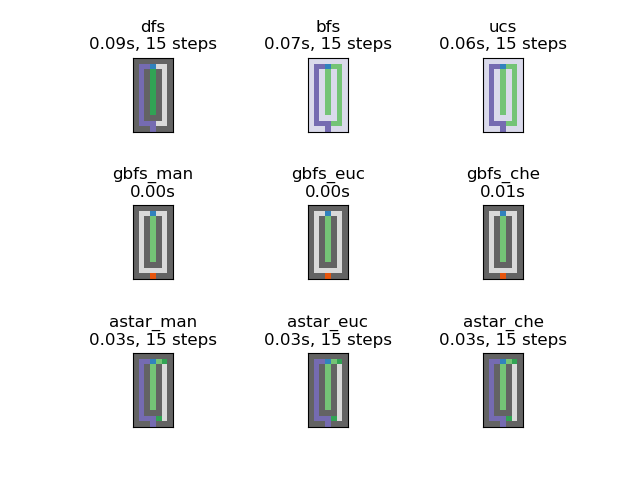

In [122]:
maze = read_maze(f'../input/level__1/input8.txt')
compare_maze(maze)

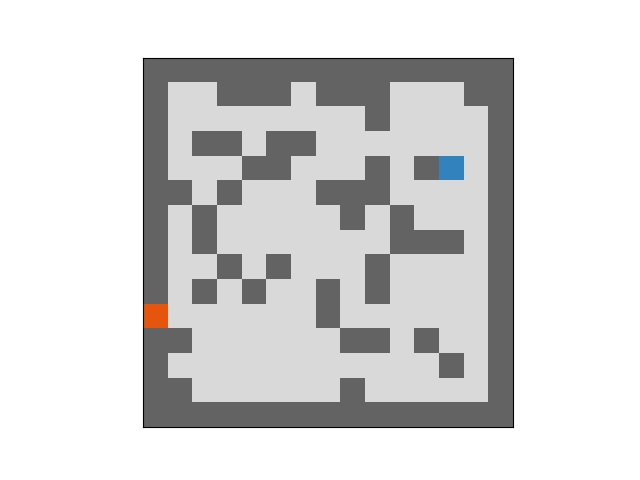

In [87]:
%matplotlib ipympl
from matplotlib import animation

def init():
    encoded_maze = [[encode_char(x) for x in line] for line in iter_maze[0]]
    im.set_data(encoded_maze)
    return im

def imaze(i):
    encoded_maze = [[encode_char(x) for x in line] for line in iter_maze[i]]
    im.set_data(encoded_maze)
    return im

fig = plt.figure()

encoded_maze = [[encode_char(x) for x in line] for line in iter_maze[0]]
im = plt.imshow(encoded_maze, cmap = 'rainbow')

plt.xticks(color = 'w')
plt.yticks(color = 'w')
plt.tick_params(bottom = False, left = False)

anim = animation.FuncAnimation(fig, func = imaze, init_func = init, frames = range(1, len(iter_maze)), interval = 20, repeat = False)